## Imports 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 


if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

In [3]:
os.chdir(root)
from data_treatment.box_creator import create_binary_box

df = pd.read_csv('database.csv')
df = create_binary_box(df, relative_threshold = 0.05, box_length=5).set_index("Date").dropna(axis = 0)

## Our model 

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

prescale_X = df.drop(columns="Box")
y = df[["Box"]]
x = (prescale_X - prescale_X.mean())/prescale_X.std()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
ridge = LogisticRegression(penalty="l2", solver="newton-cg", C = 0.3)
ridge.fit(X_train, y_train)

score= ridge.score(X_train, y_train)
score

C:\Users\maria\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7198966408268734

### Is our class imbalanced ?

In [15]:
print(len(y_test.loc[y_test['Box']==1])/len(y_test))

0.44008264462809915


### Confusion Matrix

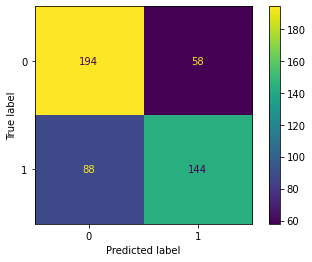

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(ridge, X_test, y_test)


## Getting our precision, recall and f-1 scores

In [6]:
y_pred= ridge.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       252
           1       0.71      0.62      0.66       232

    accuracy                           0.70       484
   macro avg       0.70      0.70      0.70       484
weighted avg       0.70      0.70      0.70       484



### The ROC Curve (receiver operating characteristic)\
plots the true positive rate against the false positive rate \
ie plots sensitivity versus 1- specificity 

In [7]:
y_scores= ridge.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

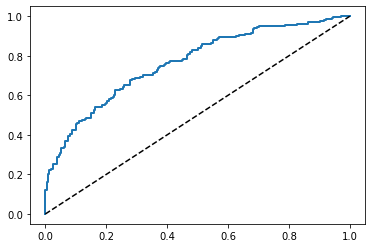

In [8]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label= label)
    plt.plot([0,1], [0,1], 'k--') 
    return 

plot_roc_curve(fpr, tpr)
plt.show()

### Area under the curve 

In [9]:
roc_auc_score(y_test, y_scores)

0.7639915161466885

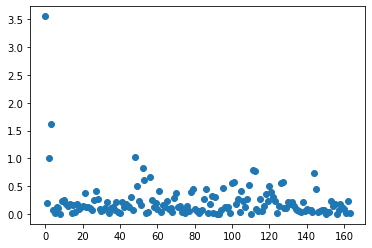

In [10]:
plt.scatter(x=range(0,X_test.shape[1]), y=abs(ridge.coef_))

In [11]:
import statsmodels.api as sm

log_reg = sm.Logit(y_train, sm.add_constant(X_train))

p_val = log_reg.fit_regularized(L1_wt=0.).pvalues

C:\Users\maria\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Iteration limit reached    (Exit mode 9)
            Current function value: 0.4887882543626087
            Iterations: 1000
            Function evaluations: 1002
            Gradient evaluations: 1000


C:\Users\maria\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\maria\anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\maria\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [12]:
X_train.loc[:,(p_val.iloc[1:]<=0.2).values]

,PX_OPEN_VIX_volatility,PX_HIGH_VIX_volatility,PX_LAST_VIX_volatility,OPEN_INT_TOTAL_PUT_VIX_volatility,VOLATILITY_30D_VIX_volatility,VOLATILITY_90D_VIX_volatility,VOLATILITY_360D_VIX_volatility,3MTH_IMPVOL_90.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_90.0%MNY_DF_VIX_volatility,PX_HIGH_SPX_volatility,VOLATILITY_30D_SPX_volatility,VOLATILITY_360D_SPX_volatility,HIST_CALL_IMP_VOL_SPX_volatility,3MTH_IMPVOL_110.0%MNY_DF_SPX_volatility,6MTH_IMPVOL_100.0%MNY_DF_SPX_volatility,6MTH_IMPVOL_105.0%MNY_DF_SPX_volatility,6MTH_IMPVOL_110.0%MNY_DF_SPX_volatility,6MTH_IMPVOL_95.0%MNY_DF_SPX_volatility,12MTH_IMPVOL_110.0%MNY_DF_SPX_volatility,24MTH_IMPVOL_105.0%MNY_DF_SPX_volatility,PX_OPEN_SX5E_volatility,PX_HIGH_SX5E_volatility,PX_LOW_SX5E_volatility,PX_LAST_SX5E_volatility,OPEN_INT_TOTAL_CALL_SX5E_volatility,OPEN_INT_TOTAL_PUT_SX5E_volatility,VOLATILITY_30D_SX5E_volatility,VOLATILITY_10D_SX5E_volatility,VOLATILITY_20D_SX5E_volatility,3MTH_IMPVOL_100.0%MNY_DF_SX5E_volatility,3MTH_IMPVOL_110.0%MNY_DF_SX5E_volatility,6MTH_IMPVOL_105.0%MNY_DF_SX5E_volatility,12MTH_IMPVOL_95.0%MNY_DF_SX5E_volatility,24MTH_IMPVOL_105.0%MNY_DF_SX5E_volatility,24MTH_IMPVOL_110.0%MNY_DF_SX5E_volatility,PX_HIGH_VSTOXX_volatility,PX_LOW_VSTOXX_volatility,VOLATILITY_30D_VSTOXX_volatility,VOLATILITY_260D_VSTOXX_volatility,VOLATILITY_90D_VSTOXX_volatility,VOLATILITY_10D_VSTOXX_volatility,VOLATILITY_20D_VSTOXX_volatility,VOLATILITY_180D_VSTOXX_volatility,QMJ USA_QMJ Factors,US Generic Govt 10 Yr_US Generic Govt 10 Yr,USD SWAP SEMI 30/360 10Y_USD SWAP SEMI 30 360 10Y,ICE LIBOR USD 3 Month_ICE LIBOR USD 3 Month,US Generic Govt 3 Mth_US Generic Govt 3 Mth,PX_VOLUME_CL2,PX_LAST_Euribor3,PX_LAST_Bund10,BAB USA_BAB Factors,BAB Global_BAB Factors,S&P 500 Weeky High_SENTIMENT,Mkt-RF_F-F_Research_Data_5_Factors_2x3_daily,SMB_F-F_Research_Data_5_Factors_2x3_daily,RMW_F-F_Research_Data_5_Factors_2x3_daily,RF_F-F_Research_Data_5_Factors_2x3_daily
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-25,-0.683924,-0.690967,-0.684586,-0.160821,0.036430,0.126363,1.071813,0.058815,0.219758,0.798157,-0.552499,-0.588626,-0.939298,-0.593850,-0.836898,-0.888210,-0.814874,-0.760533,-0.914164,-0.739806,0.059054,0.017825,0.063213,0.028265,-0.807447,-0.122264,-0.513944,-0.889655,-0.754685,-1.097300,-1.154361,-1.173856,-1.226370,-1.060544,-1.051291,-0.948629,-0.987809,1.001972,1.604793,0.698596,0.017971,0.181822,1.980867,0.229948,0.275670,0.172326,0.222284,0.274577,-0.604188,-0.607627,-0.476192,0.319572,0.044522,0.736047,0.691222,-0.945363,0.175854,0.302606
2016-02-02,0.461172,0.431571,0.561870,0.025221,0.555348,0.503326,0.927488,0.814324,0.909153,-0.435046,0.659576,0.040576,0.694740,0.324338,0.599466,0.567088,0.454534,0.596781,0.453703,0.531188,-0.964565,-1.018547,-1.086829,-1.103379,-0.473208,-1.026924,0.929138,1.224961,1.094099,1.282758,1.402982,1.249674,1.211733,0.870191,0.888329,1.024517,1.053706,0.797135,0.209912,-0.322992,0.127321,0.593980,0.367038,1.845541,-0.661086,-0.740162,-0.719909,-0.689302,-0.110469,-0.517590,-0.528787,1.333423,1.652118,-0.472012,-1.833196,-0.243866,0.699896,-0.717101
2015-08-27,1.197761,1.306215,1.091838,0.686153,2.029971,1.418006,0.385677,1.136476,0.525911,-0.361630,0.841196,-0.338084,0.798489,0.253910,0.395625,0.351550,0.250181,0.423615,0.197708,0.058963,-0.515257,-0.388971,-0.460454,-0.382838,-0.111313,-0.423101,1.512738,3.221303,2.104387,1.143487,1.124796,1.055467,0.704412,0.212400,0.501263,1.281378,1.365046,1.517685,0.541435,0.644556,2.933125,2.018508,0.424370,-1.799589,-0.379761,-0.368105,-0.881615,-0.855166,-0.583173,-0.445561,-0.271720,-0.675965,-1.731508,-0.221638,2.091694,-1.009135,-0.846028,-0.862774
2009-05-18,1.938180,1.658177,1.624380,-0.972232,-0.970413,-0.839561,-0.311105,-0.471802,-0.347029,-1.820230,1.571499,3.528239,1.706287,2.434268,2.305091,2.473690,2.659016,2.142344,2.938981,3.031549,-2.435454,-2.321525,-2.429146,-2.262428,3.656581,1.803359,1.000231,1.025613,0.860956,2.091391,2.375001,2.535875,2.559091,3.471498,3.480969,1.748443,1

In [13]:
X_train

,PX_OPEN_VIX_volatility,PX_HIGH_VIX_volatility,PX_LOW_VIX_volatility,PX_LAST_VIX_volatility,VOLUME_TOTAL_CALL_VIX_volatility,PUT_CALL_VOLUME_RATIO_CUR_DAY_VIX_volatility,VOLUME_TOTAL_PUT_VIX_volatility,TOT_OPT_VOLUME_CUR_DAY_VIX_volatility,OPEN_INT_TOTAL_CALL_VIX_volatility,OPEN_INT_TOTAL_PUT_VIX_volatility,VOLATILITY_30D_VIX_volatility,VOLATILITY_260D_VIX_volatility,VOLATILITY_90D_VIX_volatility,VOLATILITY_60D_VIX_volatility,VOLATILITY_360D_VIX_volatility,VOLATILITY_10D_VIX_volatility,VOLATILITY_20D_VIX_volatility,VOLATILITY_180D_VIX_volatility,HIST_CALL_IMP_VOL_VIX_volatility,3MTH_IMPVOL_100.0%MNY_DF_VIX_volatility,3MTH_IMPVOL_105.0%MNY_DF_VIX_volatility,3MTH_IMPVOL_110.0%MNY_DF_VIX_volatility,3MTH_IMPVOL_90.0%MNY_DF_VIX_volatility,3MTH_IMPVOL_95.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_100.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_105.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_110.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_90.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_95.0%MNY_DF_VIX_volatility,PX_OPEN_SPX_volatility,PX_HIGH_SPX_volatility,PX_LOW_SPX_volatility,PX_LAST_SPX_volatility,PX_VOLUME_SPX_volatility,VOLUME_TOTAL_CALL_SPX_volatility,PUT_CALL_VOLUME_RATIO_CUR_DAY_SPX_volatility,VOLUME_TOTAL_PUT_SPX_volatility,TOT_OPT_VOLUME_CUR_DAY_SPX_volatility,OPEN_INT_TOTAL_CALL_SPX_volatility,OPEN_INT_TOTAL_PUT_SPX_volatility,...,US Generic Govt 10 Yr_US Generic Govt 10 Yr,USD SWAP SEMI 30/360 10Y_USD SWAP SEMI 30 360 10Y,ICE LIBOR USD 3 Month_ICE LIBOR USD 3 Month,US Generic Govt 3 Mth_US Generic Govt 3 Mth,USD SWAP OIS 3M_USD SWAP OIS 3M,PX_OPEN_CL1,PX_HIGH_CL1,PX_LOW_CL1,PX_LAST_CL1,PX_VOLUME_CL1,PX_OPEN_CL2,PX_HIGH_CL2,PX_LOW_CL2,PX_LAST_CL2,PX_VOLUME_CL2,PX_OPEN_CL3,PX_HIGH_CL3,PX_LOW_CL3,PX_LAST_CL3,PX_VOLUME_CL3,PX_LAST_Euribor3,PX_LAST_Bund10,BAB USA_BAB Factors,BAB Global_BAB Factors,Bullish_SENTIMENT,Neutral_SENTIMENT,Bearish_SENTIMENT,Bullish 8-week Mov Avg_SENTIMENT,Bull-Bear Spread_SENTIMENT,S&P 500 Weeky High_SENTIMENT,S&P 500 Weekly Low_SENTIMENT,S&P 500 Weekly Close_SENTIMENT,ST_Rev_F-F_ST_Reversal_Factor_daily,Mkt-RF_F-F_Research_Data_5_Factors_2x3_daily,SMB_F-F_Research_Data_5_Factors_2x3_daily,HML_F-F_Research_Data_5_Factors_2x3_daily,RMW_F-F_Research_Data_5_Factors_2x3_daily,CMA_F-F_Research_Data_5_Factors_2x3_daily,RF_F-F_Research_Data_5_Factors_2x3_daily,Mom _F-F_Momentum_Factor_daily
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-25,-0.683924,-0.690967,-0.699595,-0.684586,-0.247374,-0.278866,-0.432035,-0.332615,0.140975,-0.160821,0.036430,1.412265,0.126363,-0.131693,1.071813,-0.862272,-0.736697,1.838985,0.169508,0.155246,0.203995,0.260439,0.058815,0.115957,0.084393,0.076865,0.085849,0.219758,0.142908,0.776334,0.798157,0.797272,0.814171,-0.560211,1.445195,-1.283985,0.393190,0.817422,0.232729,0.352499,...,0.275670,0.172326,0.222284,0.274577,0.182098,0.374312,0.374078,0.395030,0.399426,0.886382,0.292756,0.287114,0.318674,0.321368,-0.604188,0.257185,0.253257,0.287566,0.290615,-0.520744,-0.607627,-0.476192,0.319572,0.044522,-0.179261,1.148380,-0.931778,0.091429,0.450923,0.736047,0.783946,0.778777,-0.680872,0.691222,-0.945363,-1.337725,0.175854,-1.070633,0.302606,1.013336
2016-02-02,0.461172,0.431571,0.601738,0.561870,0.882291,-0.491325,-0.143226,0.579313,-0.220755,0.025221,0.555348,0.846477,0.503326,0.857027,0.927488,0.378625,0.683245,1.425182,0.578384,0.817856,0.840009,0.827099,0.814324,0.804017,0.682104,0.541643,0.459871,0.909153,0.803699,-0.421451,-0.435046,-0.458426,-0.465784,0.051984,-0.509098,-0.063679,-0.481584,-0.509947,-0.450021,-0.182269,...,-0.661086,-0.740162,-0.719909,-0.689302,-0.705463,-1.538116,-1.575084,-1.577071,-1.605908,0.804286,-1.508938,-1.543914,-1.558324,-1.582872,-0.110469,-1.472144,-1.505833,-1.524737,-1.546013,0.199059,-0.517590,-0.528787,1.333423,1.652118,-0.786123,-0.082262,0.820384,-1.844966,-0.923501,-0.472012,-0.551959,-0.491519,-2.180613,-1.833196,-0.243866,-0.442811,0.699896,1.171033,-0.717101,1.123198
2015-08-27,1.197761,1.306215,1.083766,1.091838,0.884141,0.263